## CS436/5310/EE513 - Fall 2024 - PA4 (Part 1)

#### Important Instructions and Submission Guidelines:
- Naming convention for submission of this notebook is `RollNumber_PA4_Part1.ipynb` where. For example: `25100149_PA4_Part1.ipynb`
- All the cells <b>must</b> be run once before submission. If your submission's cells are not showing the results (plots etc.), marks wil be deducted
- Only the code written within this notebook's marked areas will be considered while grading. No other files will be entertained
- You are advised to follow good programming practies including approriate variable naming and making use of logical comments 


The university honor code should be maintained. Any violation, if found, will result in disciplinary action. 

In [37]:
# making all necessary imports here
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button
from scipy.io import loadmat
import math

# if you have to make any imports, do so here

### Task 1

In this task, you will be exploring different variations for camera setups, by varying the extrinsic and intrinsic parameters.


1) Load the 3d points from `lego_model.mat`
2) Visualize the 3D Model
3) Take images of the model with different camera setups

<b>Note:</b> Code for loading the point cloud and visualizing it has been given to you. Further build on it and take images of the model and visualize them

In [38]:
# function to load the 3d model
def load_model(file_path):
    # Load teapot data
    data = loadmat(file_path)
    return data['verts']
    

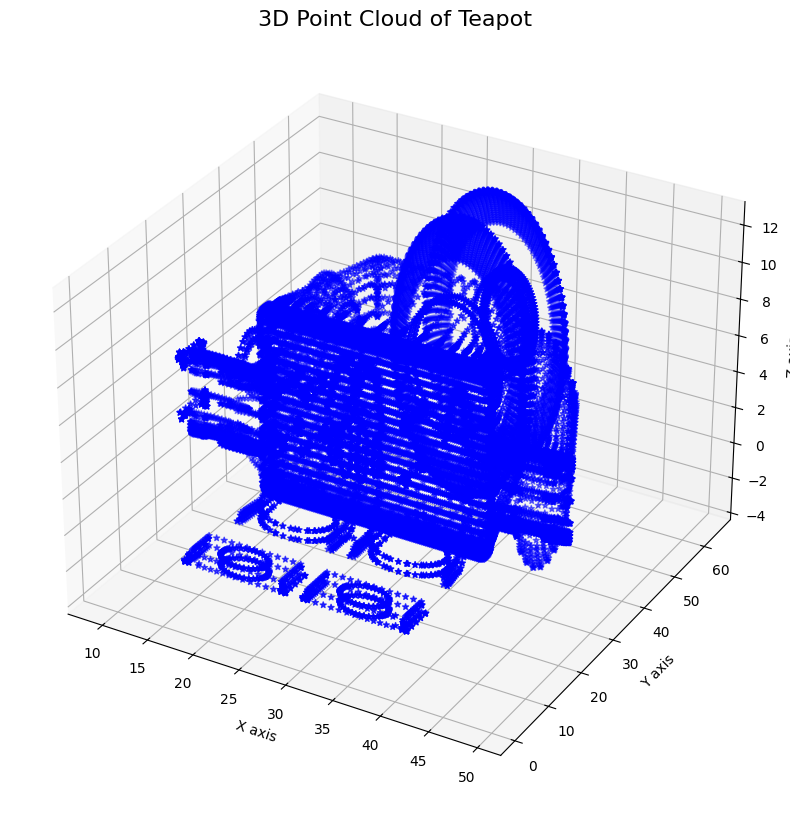

In [39]:
x = load_model('lego_model.mat')
# extracting points(coordinates) from vertices
a = []
b = []
c = []
for points in x:
    # print(points)
    a.append(points[0])
    b.append(points[1])
    c.append(points[2])

# 3D plotting the extracted points
fig = plt.figure(figsize=(12, 10))


ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Point Cloud of Teapot', fontsize=16)

ax.scatter(a, b, c, c='b', marker='*')
# print (len(a))

### Define Helper Functions to setup the Camera Matrix and VIsualization of Results

1) You may define any helper functions you deem necessary.
2) Functions to visualize the results are already provided. Make sure to only use these functions to view your results.

 <b>Hint: </b> 2Dpoints = K[R|T]*3DPoints

In [40]:
pts =[]
pts.append(a)
pts.append(b)
pts.append(c)
pts=np.array(pts)
pts=pts.T

### Helper Functions 

- A helper function to visualize your images is provided below: `visualize_points`.
- You may make other helper functions here as per your need

In [41]:
def visualize_points(all_projected, all_captions):

    """
    Visualize 2D points for different images with global axis scaling.

    all_projected - list of 2d points for each image (each element is an image)
    all_captions - list of captions for each image
    """
    # Calculate global xlim and ylim for all points
    all_points = np.vstack(all_projected)
    x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
    y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
    x_pad = (x_max - x_min) * 0.1  # 10% padding
    y_pad = (y_max - y_min) * 0.1
    xlim = [x_min - x_pad, x_max + x_pad]
    ylim = [y_min - y_pad, y_max + y_pad]

    # Plot each focal length in a subplot
    fig, axes = plt.subplots(1, len(all_captions), figsize=(12, 6))
    
    for i, (f, projected) in enumerate(zip(all_captions, all_projected)):
        axes[i].scatter(projected[:, 0], projected[:, 1], c='b', marker='.', s=1)
        axes[i].set_title(f)
        axes[i].set_xlim(xlim)
        axes[i].set_ylim(ylim)
        axes[i].grid(True)

### Scenario 1: Exploring the Impact of Focal Length (10 Marks)

Imagine a photographer capturing a LEGO figure at different focal lengths to examine how the perceived size and depth change without moving the camera. In this task, you'll simulate this scenario by projecting a set of 3D points at varying focal lengths.

#### Objective

Using three distinct focal lengths—400mm, 800mm, and 1600mm—project a set of 3D points representing the LEGO figure onto a 2D plane. Assume the camera's position and orientation remain fixed for each focal length.

- <b>Camera Position:</b> For simplicity, we’ll assume the camera is positioned directly along the z-axis at [-1000], so it’s 1000 units away from the LEGO figure. This default translation keeps the camera stationary across focal lengths and emphasizes the effect of focal length alone.

#### Task

Implement the function `scenario_1_varying_focal_length(pts)` with the following goals:
- Use the provided focal lengths to create a projection matrix for each case.
- Project the points in pts and visualize the 2D projections.

Visualize the results using `visualize_points()` to examine the differences. Observe how focal length influences the projection, creating the illusion of the LEGO figure’s size and depth changing even though the camera position is the same.

<b>Reflection</b>: Briefly comment on how varying the focal length affects the field of view, scale, and depth of the projection.



In [42]:
def make_rotation_matrix(theta, matrix_type):
        radian_theta = np.radians(theta)
        cos_theta = np.cos(radian_theta)
        sin_theta = np.sin(radian_theta)
        
        if matrix_type == "rx":
            rotation_matrix = np.array([
                [1, 0, 0, 0],
                [0, cos_theta, -sin_theta, 0],
                [0, sin_theta, cos_theta, 0],
                [0, 0, 0, 1],
            ])
        elif matrix_type == "ry":
            rotation_matrix = np.array([
                [cos_theta, 0, sin_theta, 0],
                [0, 1, 0, 0],
                [-sin_theta, 0, cos_theta, 0],
                [0, 0, 0, 1],
            ])
        elif matrix_type == "rz":
            rotation_matrix = np.array([
                [cos_theta, -sin_theta, 0, 0],
                [sin_theta, cos_theta, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1],
            ])
            
        return rotation_matrix

def perspective_transform(pts, focal_length, camera_position, px=0, py=0, theta=None, rotation_matrix_type=""):
    # Converting pts to homogenous coordinates
    homogenous_points = np.hstack((pts, np.ones((pts.shape[0], 1))))
    
    # Creating intrinsic matrix K for projection
    K = np.array([
        [focal_length, 0, px, 0],
        [0, focal_length, py, 0],
        [0, 0, 1, 0],
    ])
    
    # Creating a 4x4 rotation matrix
    if theta is not None and rotation_matrix_type != "":
        rotation_matrix = make_rotation_matrix(theta, rotation_matrix_type)
    else:
        rotation_matrix = np.eye(4)
        
    # Creating a 4x4 translation matrix
    translation_matrix = np.eye(4)
    translation_matrix[0:3, 3] = -np.array(camera_position)
    
    # Order of multiplication: T->R->K
    translated_points = translation_matrix @ homogenous_points.T # translated points
    rotated_points = rotation_matrix @ translated_points       # rotated points
    projected_points = K @ rotated_points                     # 2D projected points
    
    x = projected_points[0]
    y = projected_points[1]
    z = projected_points[2]
    
    x_2d = x / z
    y_2d = y / z
    projected_points_2d = np.vstack((x_2d, y_2d)).T
    
    return projected_points_2d

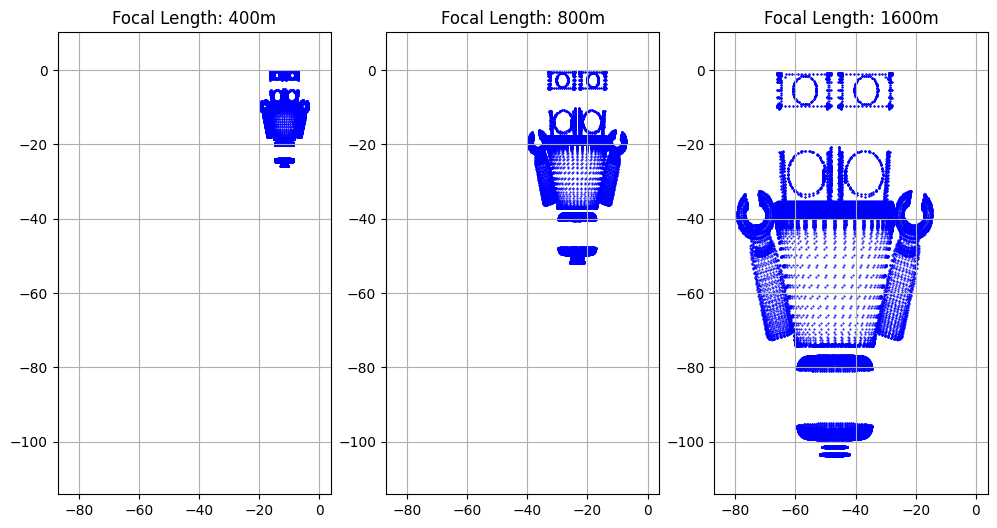

In [43]:
def scenario_1_varying_focal_length(pts):
    """
    Scenario 1: Compare different focal lengths with more dramatic differences
    """
    focal_lengths = [400, 800, 1600] # in mm
    camera_position = [0, 0, 1000] # units away from lego figure
    
    all_projected_points = []
    all_captions = []
    for i, focal_length in enumerate(focal_lengths):
        projected_points = perspective_transform(pts, focal_length, camera_position)
        
        all_projected_points.append(projected_points)
        all_captions.append(f"Focal Length: {focal_length}m")
    
    visualize_points(all_projected_points, all_captions)
    
# Example usage:
scenario_1_varying_focal_length(pts)


**Reflection:**
1. *View*: The view is smaller for less focal length, while the image view is bigger for higher focal length.
2. *Scale*: Increasing the focal length makes the object appear larger in the image which is similar to zooming in. A higher focal length magnifies the object while a shorter focus length makes the object seem smaller.
3. *Depth*: Increasing the focal length enhances the depth, making the  image seem bigger than it is. decreasing it compressed the image, making it more 2d.

### Scenario 2: Exploring the Effect of Camera Position (10 Marks)

In this scenario, imagine shifting a camera around a LEGO figure to see how changes in the camera’s position alter the perspective of the figure. Unlike Scenario 1, where focal length changed with a fixed camera position, here the focal length remains constant while the camera moves to new positions. This approach will help you observe how camera position affects the scene.

#### Objective
Using a focal length of 1200mm, project a set of 3D points representing the LEGO figure from three different camera positions:
- **Center**: Camera positioned directly along the z-axis at `(0, 0, -1000)`.
- **Right**: Camera shifted 200 units to the right, to `(200, 0, -1000)`.
- **Up**: Camera moved 200 units upward, to `(0, 200, -1000)`.

#### Task
1. Implement the function `scenario_2_camera_positions(pts)` with the following goals:
   - Use the fixed focal length and specified camera positions to create projection matrices for each position.
   - Project the points in `pts` and visualize the 2D projections.
   
2. **Visualize** the results using `visualize_points()` to analyze the differences. Notice how the perspective changes as the camera moves to different locations while keeping its focus on the LEGO figure.

3. **Reflection**: Briefly comment on how shifting the camera position affects the perceived orientation and positioning of the figure, compared to changing only the focal length in Scenario 1.

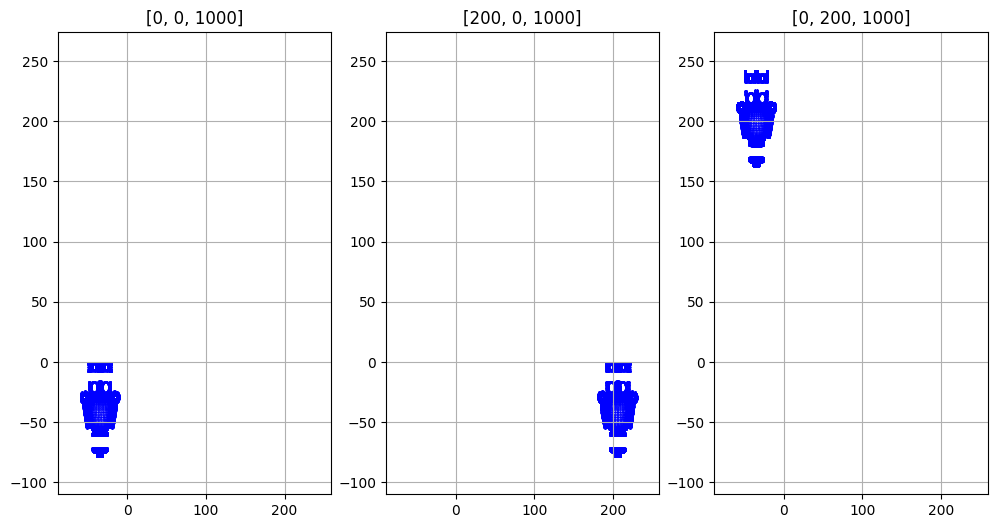

In [44]:

def scenario_2_camera_positions(pts):
    """
    Scenario 2: Compare different camera positions with more dramatic movements
    """
    focal_length = 1200 # fixed focal length
    camera_positions = {
        "center": [0, 0, 1000],
        "right":  [200, 0, 1000],
        "up":     [0, 200, 1000],
    }

    all_projected_points = []
    all_captions = []
    
    for i, (camera_position_name, camera_position) in enumerate(camera_positions.items()):
        projected_points = perspective_transform(pts, focal_length, camera_position)
        
        all_projected_points.append(projected_points)
        all_captions.append(f"{camera_position}")
    
    visualize_points(all_projected_points, all_captions)

scenario_2_camera_positions(pts)


changing the camera position translates the image itself in its background. In scenario 1, where we only changed focal length, the result was zoomed in or zoomed out images. But altering the orientation and position of the camera gives an all together differenct affect, translating the image with respect to the camera position.

### Scenario 3: Telephoto Effect vs. Camera Position (10 Marks)

This scenario demonstrates how both focal length and camera distance from the subject can influence perspective and perceived depth. You’ll explore the telephoto effect by varying the camera’s focal length and positioning it at different distances from the LEGO figure.

#### Objective
With three different setups of focal length and camera distance, observe how changes affect the projection. The three setups include:
- **Close-up**: 600mm focal length with the camera close to the LEGO figure at z = -500 units.
- **Telephoto**: 1800mm focal length with the camera further away at z = -5000 units.
- **Medium**: 1200mm focal length with the camera positioned at z = -1000 units.

#### Task
1. Implement `scenario_3_telephoto_vs_position(pts)` with the following steps:
   - For each setup, create the appropriate projection matrix and project the points in `pts`.
   - Visualize the projections with `visualize_points()` to analyze how each setup affects the appearance of the LEGO figure.

2. **Reflection**: Briefly comment on the differences in projection. How does the telephoto setup compare to the close-up, and what effect does it have on perceived scale and depth?

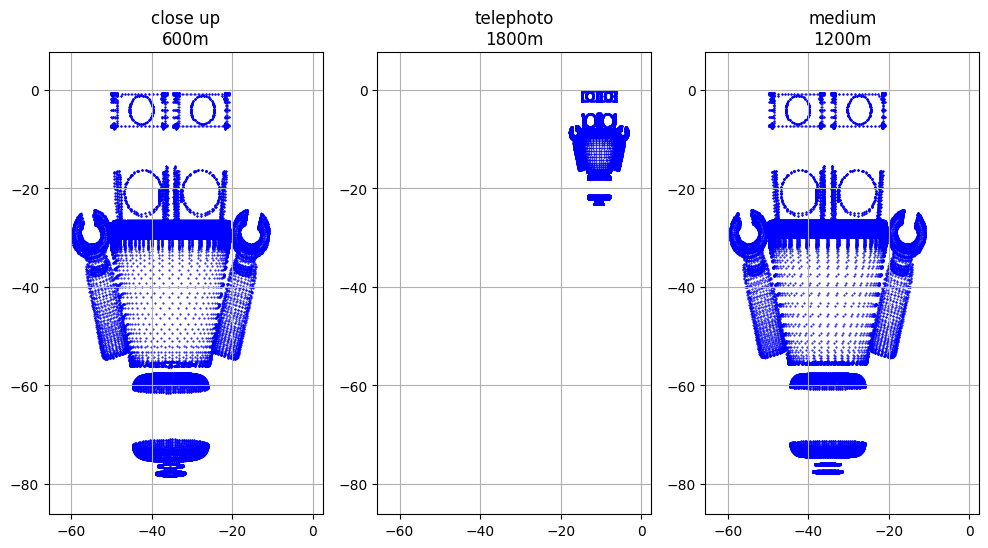

In [45]:

def scenario_3_telephoto_vs_position(pts):
    """
    Scenario 3: Compare telephoto effect vs. camera position with more pronounced differences
    """
    setups = {
        "close up": {
            "focal length": 600,
            "camera position": [0, 0, 500],
        },
        "telephoto": {
            "focal length": 1800,
            "camera position": [0, 0, 5000],
        },
        "medium": {
            "focal length": 1200,
            "camera position": [0, 0, 1000],
        },
    }
    
    all_projected_points = []
    all_captions = []
    for i, (setup_name, setup_dict) in enumerate(setups.items()):
        focal_length, camera_position = setup_dict.values()
        projected_points = perspective_transform(pts, focal_length, camera_position)
        
        all_projected_points.append(projected_points)
        all_captions.append(f"{setup_name}\n{focal_length}m")
    
    visualize_points(all_projected_points, all_captions)
    
scenario_3_telephoto_vs_position(pts)

**REFLECTION:**
1. Telephoto vs close-up: The telephoto effect results in a compressed appearance as can seen above, where objects seems closer together and scale more uniformly. This also flattens the perceived depth of the scene, making the image appear more 2 dimensional.
2. On the other hand, the close-up enhances depth-perception and scaling. the background is smaller, emphasizing the image itself. The scaling is more prominent in the close-up setup. The object fills more space.



### Scenario 4: Matching Perspective with Different Focal Lengths (20 Marks)

In this challenge, you'll experiment with achieving the same projected image at different focal lengths by adjusting the camera's distance.

#### Objective
Given an initial setup with a large focal length (e.g., 5000mm) and the camera positioned far from the LEGO figure (e.g., z = -5000 units), calculate the required **translation** to replicate the same projection if the focal length is reduced to 500mm.

#### Task
1. Implement `scenario_4_calculate_translation(pts)`, and determine the new camera position required to achieve the same image projection at a focal length of 500mm.
2. Use `visualize_points()` to confirm that the projection with the calculated translation closely matches the original setup with a 5000mm focal length.

3. **Reflection**: Comment on the relationship between focal length and camera distance. What general rule can you deduce for achieving the same projection with different focal lengths?


[0.0, 0.0, 500.0]


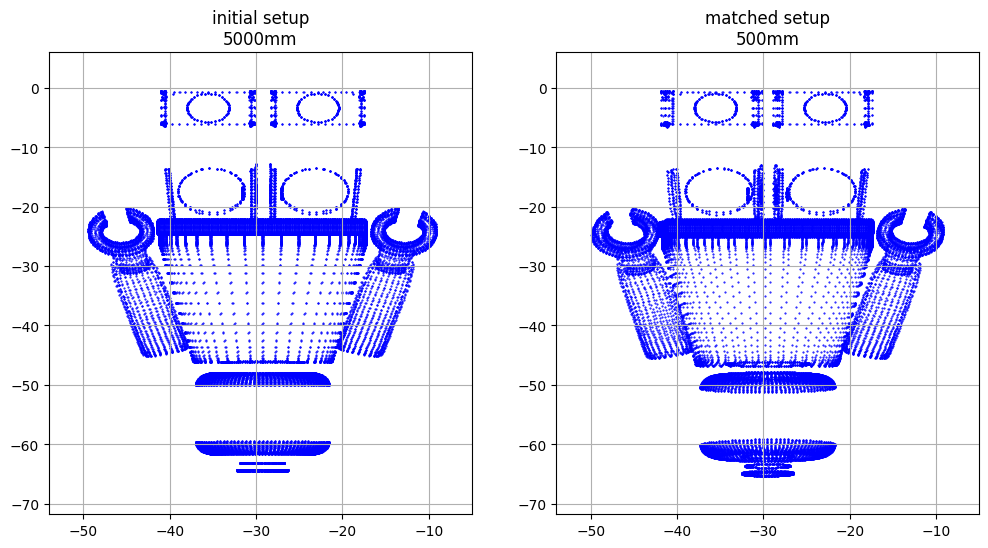

In [ ]:
def scenario_4_calculate_translation(pts):
    """
    Scenario 4: Matching Perspective with Different Focal Lengths
    """
    # Initail setup
    focal_length_initial = 5000
    camera_position_initial = [0, 0, 5000]
    
    # Calculating new camera position with new focal length
    focal_length_new = 500
    scale = focal_length_new / focal_length_initial
    camera_position_new = [x*scale for x in camera_position_initial]
    
    setups = {
        "initial setup": {
            "focal length": focal_length_initial,
            "camera position": camera_position_initial,
        },
        "matched setup": {
            "focal length": focal_length_new,
            "camera position": camera_position_new,
        },
    }
    all_projected_points = []
    all_captions = []
    for i, (setup_name, setup_dict) in enumerate(setups.items()):
        focal_length, camera_position = setup_dict.values()
        projected_points = perspective_transform(pts, focal_length, camera_position)
        
        all_projected_points.append(projected_points)
        all_captions.append(f"{setup_name}\n{focal_length}mm")
    
    visualize_points(all_projected_points, all_captions)
    
scenario_4_calculate_translation(pts)




**Reflection:**
In this scnenario, we reduced the focal length from 5000 to 500. We had to adjust the camera postion in proportion to the change in focal length. A general rule to follow is that if we scale focal length down by a certain value, we scale the camera positions as well.

### Scenario 5: Exploring the Impact of Camera Rotation (10 Marks)

This scenario allows you to observe how varying only the camera rotation (without altering focal length or camera distance) affects the projected image of the LEGO figure. You’ll explore different rotation angles around the Y-axis to see how each one changes the appearance of the subject.

#### Objective
By comparing projections at different rotations, you’ll understand how orientation alone impacts perspective, without modifying the camera's distance or focal length.

#### Setups
We’ll keep the focal length fixed at 1200mm and the camera positioned at \( z = -1000 \) units from the LEGO figure. The following rotation angles are used:
- **0°**: The camera directly faces the subject.
- **30°**: A slight rotation to the right.
- **60°**: A more pronounced rotation.
- **90°**: A side-on view with the camera positioned perpendicular to the subject.

#### Task
1. Implement `scenario_5_varying_rotation(pts)` by following these steps:
   - For each rotation angle, construct the rotation matrix and projection matrix.
   - Project the points using each setup and visualize them with `visualize_points()` to assess how each orientation impacts the figure’s appearance.

2. **Reflection**: Describe the differences in each projection. How does the rotation impact what parts of the LEGO figure are visible? How does rotating the camera change the relative positioning of points within the projection?

By focusing on rotation alone, this scenario highlights the effects of changing the camera’s orientation on perceived depth and perspective, emphasizing the role of angle in shaping the viewer's experience without any zoom or position changes.

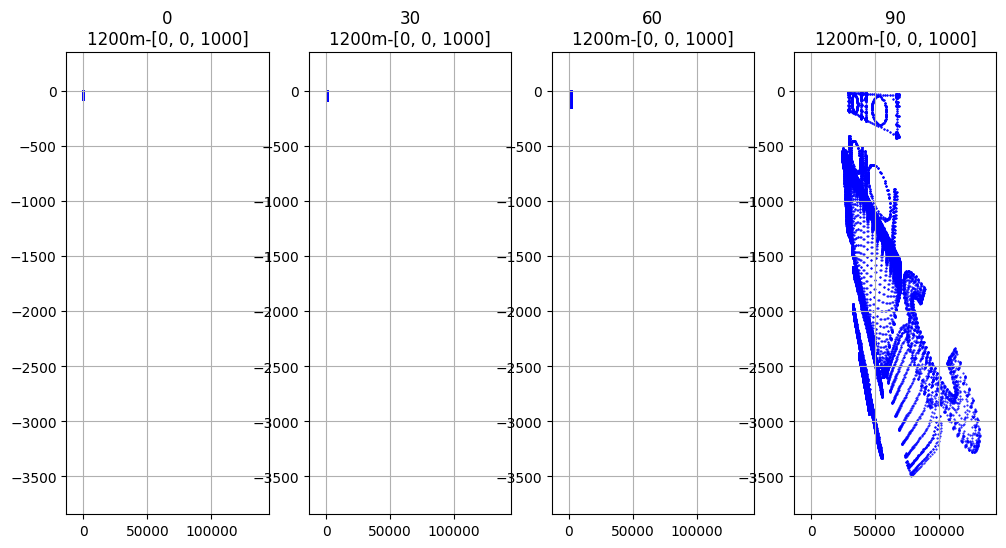

In [51]:
def scenario_5_varying_rotation(pts):
    """
    Scenario 5: Varying rotation angles while keeping focal length and position fixed.
    """
    focal_length = 1200
    camera_position = [0, 0, 1000]
    thetas = [0, 30, 60, 90]
    
    all_projected_points = []
    all_captions = []
    for i, theta in enumerate(thetas):
        projected_points = perspective_transform(pts, focal_length, camera_position, 0, 0, theta, "ry")        
        all_projected_points.append(projected_points)
        all_captions.append(f"{theta}\n{focal_length}m-{camera_position}")
    
    visualize_points(all_projected_points, all_captions)
    
scenario_5_varying_rotation(pts)


#### Thats it! You're done with PA4 (Part 1). 